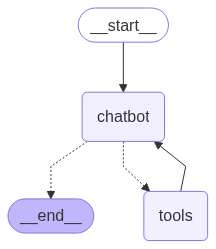

こんにちは
こんにちは！今日はどんなことをお手伝いできますか？
1たす2は？
1たす2は3です。何か他にお手伝いできることがありますか？
台湾観光について検索結果を教えて

[{"title": "台湾観光におすすめの名所＆人気のスポットランキング - 阪急交通社", "url": "https://www.hankyu-travel.com/guide/taiwan/", "content": "Image 10: 彩虹眷村彩虹眷村\n\n絶景にグルメ、ショッピング、温泉まで楽しめる台湾。台北のシンボルタワー、台北101でショッピングや眺望を楽しんだり、夜は寧夏夜市でB級グルメ三昧。足をのばして、九份の街歩きもおすすめです。そんな台湾の基本情報から観光情報まで詳しく紹介します。\n\n   観光マップ\n   おすすめ 観光スポット\n   グルメ\n   基本情報（ビザ・現地情報）\n\n台湾観光マップ\n\nMap\n\n   九份\n   台北\n   台中\n   台南\n   高雄\n\n台湾のおすすめ観光スポット総合ランキング\n\nRanking\n\n1 位Image 11: 九フン\n### 九フン\n\n台北\n『千と千尋の神隠し』の舞台として脚光を浴びた山間部にある小さな町。赤提灯が並ぶ風景を求め、大勢の観光客が訪れます。\n\n2 位Image 12: 士林夜市\n### 士林夜市\n\n台北\n台北市最大規模の観光夜市です。台湾のローカルフードを提供する飲食屋台などさまざまな屋台が軒を連ねます。\n\n3 位Image 13: 日月潭\n### 日月潭 [...] 台中\n周囲を山々に囲まれた台湾最大の淡水湖。台湾3大観光地の一つとして人気で、四季折々の美しい景観が楽しめます。\n\n4 位Image 14: 台北101\n### 台北101\n\n台北\n地上101階建て、高さ508mの超高層ビル。毎年元旦0時にはカウントダウン花火を実施しています。\n\n5 位Image 15: 野柳\n### 野柳\n\n新北\n全長約1,700mの長さの岬。海食風化と地殻変動により、大自然の石彫芸術のような独特の景観を生み出しました。\n\n6 位Image 16: 龍虎塔\n### 龍虎塔\n\n高雄\n1976年に建てられた7階建の塔です。龍

In [2]:
# 必要なモジュールをインポート
import os
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from typing import Annotated
from typing_extensions import TypedDict
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver
from IPython.display import Image, display

# ===== Stateクラスの定義 =====
class State(TypedDict):
    messages: Annotated[list, add_messages]

# ===== グラフの構築 =====
def build_graph(model_name):
    # ソースコードを記述
    tool = TavilySearchResults(max_results=2)
    tools = [tool]

    # グラフのインスタンスを作成
    graph_builder = StateGraph(State)

    # 言語モデルの定義
    llm = ChatOpenAI(model_name=model_name)

    # 変更点：ツール定義の紐づけ
    llm_with_tools = llm.bind_tools(tools)

    # チャットボットノードの作成
    def chatbot(state: State):
         return {"messages": [llm_with_tools.invoke(state["messages"])]}

    # グラフにチャットボットノードを追加
    graph_builder.add_node("chatbot", chatbot)
    return graph_builder, tools


# ===== グラフ実行関数 =====
def stream_graph_updates(graph: StateGraph, user_input: str):
    # ソースコードを記述
    # グラフの実行と結果の表示
    events = graph.stream(
        {"messages": [("user", user_input)]},
        {"configurable": {"thread_id": "1"}},
        stream_mode="values")
    # 結果をストリーミングで得る
    for event in events:
        print(event["messages"][-1].content, flush=True)


# ===== メイン実行ロジック =====
# 環境変数の読み込み
load_dotenv("../../.env")
os.environ['OPENAI_API_KEY'] = os.environ['API_KEY']

# モデル名
MODEL_NAME = "gpt-4o-mini"

# グラフの作成
graph_builder, tools = build_graph(MODEL_NAME)

# ツールノードの作成
tool_node = ToolNode(tools)

# グラフにツールノードを追加
graph_builder.add_node("tools", tool_node)

# 条件付エッジの作成
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition, # ツール呼出と判断したらツールノードを呼ぶ
)

# ツールが呼び出されるたびに、チャットボットに戻って次のステップを決定
# ツールからチャットボットへの戻りエッジを作成
graph_builder.add_edge("tools", "chatbot")

# 開始ノードの指定
graph_builder.set_entry_point("chatbot")

# 記憶を持つ実行可能なステートグラフの作成
memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

# グラフの可視化
display(Image(graph.get_graph().draw_mermaid_png()))

# メインループ
while True:
    user_input = input("質問:")
    if user_input.strip()=="":
        print("ありがとうございました!")
        break
    stream_graph_updates(graph, user_input)







